In [1]:

import argparse
import os
import pprint
import shutil
import sys

import logging
import time
import timeit
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
from tensorboardX import SummaryWriter

import _init_paths
import models
import datasets
from config import config
from config import update_config
from core.criterion import CrossEntropy, OhemCrossEntropy
from core.function import train, validate
from utils.modelsummary import get_model_summary
from utils.utils import create_logger, FullModel

import pickle
import glob
from torchvision import transforms
import PIL.Image as Image

/opt/conda/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 4.9 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 4.9 or higher.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(ABI_INCOMPATIBILITY_WARNING.format(compiler))
/opt/conda/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please u

In [2]:
with open('../train_args.pkl', 'rb') as f:
       args = pickle.load(f)
args.cfg = '../'+args.cfg #changed
update_config(config, args)


In [3]:
config.CUDNN.keys()

dict_keys(['BENCHMARK', 'DETERMINISTIC', 'ENABLED'])

In [4]:
logger, final_output_dir, tb_log_dir = create_logger(
        config, args.cfg, 'train')
logger.info(pprint.pformat(args))
logger.info(config)
writer_dict = {
        'writer': SummaryWriter(tb_log_dir),
        'train_global_steps': 0,
        'valid_global_steps': 0,
    }

Namespace(cfg='../experiments/cityscapes/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484.yaml', opts=[])
AUTO_RESUME: False
CLASSIFIER_LR: 0.0001
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  DATASET: cityscapes
  EXTRA_TRAIN_SET: 
  NUM_CLASSES: 19
  ROOT: data/
  TEST_SET: list/cityscapes/val.lst
  TRAIN_SET: list/cityscapes/train.lst
DEBUG:
  DEBUG: False
  SAVE_BATCH_IMAGES_GT: False
  SAVE_BATCH_IMAGES_PRED: False
  SAVE_HEATMAPS_GT: False
  SAVE_HEATMAPS_PRED: False
DISCRIMINATOR_LR: 0.0001
DOMAIN2_FOLDER:  
GPUS: (0, 1, 2, 3)
LOG_DIR: log
LOG_INTERVAL: 50
LOSS:
  CLASS_BALANCE: False
  OHEMKEEP: 131072
  OHEMTHRES: 0.9
  USE_OHEM: False
MODEL:
  EXTRA:
    FINAL_CONV_KERNEL: 1
    STAGE1:
      BLOCK: BOTTLENECK
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4]
      NUM_CHANNELS: [64]
      NUM_MODULES: 1
      NUM_RANCHES: 1
    STAGE2:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4]
      NUM_BRANCHES: 2
      NUM_CHANN

=> creating output/cityscapes/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484
=> creating log/cityscapes/seg_hrnet/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484_2020-01-06-20-03


In [5]:
'datasets.'+config.DATASET.DATASET

'datasets.cityscapes'

In [6]:
cudnn.benchmark = config.CUDNN.BENCHMARK
cudnn.deterministic = config.CUDNN.DETERMINISTIC
cudnn.enabled = config.CUDNN.ENABLED
# gpus = list(config.GPUS)
gpus = [0,1] # changed

# build model
model = eval('models.'+config.MODEL.NAME +
             '.get_seg_model')(config)

config.TRAIN.IMAGE_SIZE[0] = int(512)
config.TRAIN.IMAGE_SIZE[1] = int(256)

dump_input = torch.rand(
    (1, 3, config.TRAIN.IMAGE_SIZE[1], config.TRAIN.IMAGE_SIZE[0])
)
logger.info(get_model_summary(model.cuda(), dump_input.cuda()))

# copy model file
this_dir = os.path.dirname('./') #changed
models_dst_dir = os.path.join(final_output_dir, 'models')
if os.path.exists(models_dst_dir):
    shutil.rmtree(models_dst_dir)
shutil.copytree(os.path.join(this_dir, '../lib/models'), models_dst_dir)

# prepare data
crop_size = (int(config.TRAIN.IMAGE_SIZE[1]), int(config.TRAIN.IMAGE_SIZE[0]))
train_dataset = eval('datasets.'+config.DATASET.DATASET)(
                    root = '../' + config.DATASET.ROOT, #changed
#                     root=config.DATASET.ROOT,
                    list_path=config.DATASET.TRAIN_SET,
                    num_samples=None,
                    num_classes=config.DATASET.NUM_CLASSES,
                    multi_scale=config.TRAIN.MULTI_SCALE,
                    flip=config.TRAIN.FLIP,
                    ignore_label=config.TRAIN.IGNORE_LABEL,
                    base_size=config.TRAIN.BASE_SIZE,
                    crop_size=crop_size,
                    downsample_rate=config.TRAIN.DOWNSAMPLERATE,
                    scale_factor=config.TRAIN.SCALE_FACTOR)

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.TRAIN.BATCH_SIZE_PER_GPU*len(gpus),
    shuffle=config.TRAIN.SHUFFLE,
    num_workers=0, #config.WORKERS,
    pin_memory=True,
    drop_last=True)

if config.DATASET.EXTRA_TRAIN_SET:
    extra_train_dataset = eval('datasets.'+config.DATASET.DATASET)(
                root = '../' + config.DATASET.ROOT, #changed
#                 root=config.DATASET.ROOT,
                list_path=config.DATASET.EXTRA_TRAIN_SET,
                num_samples=None,
                num_classes=config.DATASET.NUM_CLASSES,
                multi_scale=config.TRAIN.MULTI_SCALE,
                flip=config.TRAIN.FLIP,
                ignore_label=config.TRAIN.IGNORE_LABEL,
                base_size=config.TRAIN.BASE_SIZE,
                crop_size=crop_size,
                downsample_rate=config.TRAIN.DOWNSAMPLERATE,
                scale_factor=config.TRAIN.SCALE_FACTOR)

    extra_trainloader = torch.utils.data.DataLoader(
        extra_train_dataset,
        batch_size=config.TRAIN.BATCH_SIZE_PER_GPU*len(gpus),
        shuffle=config.TRAIN.SHUFFLE,
        num_workers=config.WORKERS,
        pin_memory=True,
        drop_last=True)

test_size = (config.TEST.IMAGE_SIZE[1], config.TEST.IMAGE_SIZE[0])
test_dataset = eval('datasets.'+config.DATASET.DATASET)(
                    root = '../' + config.DATASET.ROOT, #changed
#                     root=config.DATASET.ROOT,
                    list_path=config.DATASET.TEST_SET,
                    num_samples=config.TEST.NUM_SAMPLES,
                    num_classes=config.DATASET.NUM_CLASSES,
                    multi_scale=False,
                    flip=False,
                    ignore_label=config.TRAIN.IGNORE_LABEL,
                    base_size=config.TEST.BASE_SIZE,
                    crop_size=test_size,
                    downsample_rate=1)

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.TEST.BATCH_SIZE_PER_GPU*len(gpus),
    shuffle=False,
    num_workers=0,#config.WORKERS,
    pin_memory=True)

=> init weights from normal distribution
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")

Total Parameters: 65,773,843
----------------------------------------------------------------------------------------------------------------------------------
Total Multiply Adds (For Convolution and Linear Layers only): 43.510986328125 GFLOPs
----------------------------------------------------------------------------------------------------

In [7]:
#config.TRAIN.LR=0.0001
LR = 0.001

In [8]:
from models import segnet_vj

domain_network = segnet_vj.segnet_domain_adapt(config)
domain_network.init_weights(config.MODEL.PRETRAINED)

pretrained_dict = torch.load('../hrnet_w48_cityscapes_cls19_1024x2048_ohem_trainvalset.pth')

model_dict = domain_network.state_dict()
pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items()
                    if k[6:] in model_dict.keys()}
model_dict.update(pretrained_dict)

domain_network.load_state_dict(model_dict)


optimizer = torch.optim.SGD([{'params':
                  filter(lambda p: p.requires_grad,
                         domain_network.parameters()),
                  'lr': LR/10}],
                lr=LR/10,
                momentum=config.TRAIN.MOMENTUM,
                weight_decay=config.TRAIN.WD,
                nesterov=config.TRAIN.NESTEROV,
                )
classifier_criterion = CrossEntropy(ignore_label=config.TRAIN.IGNORE_LABEL,
                             weight=train_dataset.class_weights)


# find output dimension of our model
domain_network.eval()
domain_network.float()
domain_network.cuda()
with torch.no_grad():
    feat = domain_network.forward_feature(dump_input.cuda())
    pred = domain_network.forward_classifier(feat)
disc_input_size = feat.shape[1]

discriminator = segnet_vj.FCN_discriminator(in_channels=disc_input_size, out_classes=2)

# Define discriminator loss
disc_criterion = nn.CrossEntropyLoss()

disc_optimizer = torch.optim.SGD([{'params':
                filter(lambda p: p.requires_grad,
                     discriminator.parameters()),
                'lr': LR}],
                lr=LR,
                momentum=config.TRAIN.MOMENTUM,
                weight_decay=config.TRAIN.WD,
                nesterov=config.TRAIN.NESTEROV,
                )
full_network = segnet_vj.Full_Adaptation_Model(network = domain_network, loss_classifier=classifier_criterion,\
                            discriminator=discriminator, loss_discriminator=disc_criterion)
# full_network.cuda()

=> init weights from normal distribution
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [9]:
try:
    full_network.network.load_state_dict(torch.load('../adapt_classification_net_1.pth'))
    full_network.discriminator.load_state_dict(torch.load('../adapt_discriminator_net_1.pth'))
    print("Network loaded from saved models")
except:
    print("Network loaded from scratch (except classification net)")

full_network_model = nn.DataParallel(full_network, device_ids=gpus).cuda()

Network loaded from saved models


In [10]:
(config.TRAIN.IMAGE_SIZE[0], config.TRAIN.IMAGE_SIZE[1])

(512, 256)

In [11]:
import glob
from PIL import Image
import torchvision.transforms as transforms

class Image_loader():
    def __init__(self, folder_path, img_shape):
        
        self.folder_path = folder_path
        self.img_shape = img_shape
        self.file_list = glob.glob(folder_path + "/*jpg")
        self.trans = transforms.ToTensor()
        self.order = np.random.choice([i for i in range(len(self.file_list))], len(self.file_list), replace=False)
        self.current_index = 0
    def get_images(self,batch_size):
        img_list = []
        for i in range(batch_size):
            img = Image.open(self.file_list[self.order[self.current_index]])
            self.current_index = (self.current_index+1)%len(self.file_list)
            
            img_list.append( self.trans(img.resize(self.img_shape)) )
        img_dataset = torch.stack(img_list)
        return img_dataset

In [12]:
folder_path = '../domain2_images'
img_shape = (config.TRAIN.IMAGE_SIZE[0], config.TRAIN.IMAGE_SIZE[1])

img_loader = Image_loader(folder_path = '../domain2_images', img_shape=img_shape)

In [13]:
full_network.network.conv2.weight[5,0]

tensor([[-0.0001,  0.0034, -0.0080],
        [ 0.0002,  0.0075,  0.0146],
        [ 0.0027, -0.0164,  0.0141]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [14]:
full_network.network.train()
full_network.discriminator.train()

FCN_discriminator(
  (norm1): BatchNorm2d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(720, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_op): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [15]:
full_network_model.train()
for i_iter, batch in enumerate(trainloader, 0):
    disc_optimizer.zero_grad()
    optimizer.zero_grad()

    images, labels, _, _ = batch
    d2_images = img_loader.get_images(batch_size=len(images))
    label_discriminator = np.zeros([len(images)*2])
    label_discriminator[-len(d2_images):] = 1
    label_discriminator = torch.from_numpy(label_discriminator)
    
    loss = full_network_model(input_d1=images, label_d1=labels.cuda().long(), input_d2=d2_images,\
                                    label_discriminator=label_discriminator.cuda().long(), lamda=0.25)
    final_loss = torch.mean(loss)
    final_loss.backward()
    disc_optimizer.step()
    optimizer.step()
    print("final loss:", final_loss.item(), "\n")
    if (i_iter == 25):
        break

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:58: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


final loss: 0.38909125328063965 

final loss: 0.2887750267982483 

final loss: 0.2844560742378235 

final loss: 0.28775301575660706 

final loss: 0.37474367022514343 

final loss: 0.23774927854537964 

final loss: 0.2232499122619629 

final loss: 0.30744487047195435 

final loss: 0.2909800708293915 

final loss: 0.25113558769226074 

final loss: 0.2976453900337219 

final loss: 0.2863072156906128 

final loss: 0.2929839789867401 

final loss: 0.352222204208374 

final loss: 0.2917228639125824 

final loss: 0.2786935567855835 

final loss: 0.24487236142158508 

final loss: 0.31356969475746155 

final loss: 0.24243152141571045 

final loss: 0.20225152373313904 

final loss: 0.3078168034553528 

final loss: 0.24506868422031403 

final loss: 0.4652028977870941 

final loss: 0.3139920234680176 

final loss: 0.29434460401535034 

final loss: 0.328088641166687 



In [16]:
full_network.network.conv2.weight[5,0]

tensor([[-0.0001,  0.0034, -0.0080],
        [ 0.0002,  0.0075,  0.0146],
        [ 0.0026, -0.0164,  0.0141]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [26]:
import torch.cuda as cuda
cuda.memory_allocated(0) /(1024*1024)

1454.02099609375

Save the model

In [23]:
torch.save(full_network.network.state_dict(), '../adapt_classification_net_1.pth')
torch.save(full_network.discriminator.state_dict(), '../adapt_discriminator_net_1.pth')

Now have a module which will take a list of image paths and compare the segmentation output from domain adapted network and initial network

In [18]:
base_network = segnet_vj.segnet_domain_adapt(config)
base_network.init_weights(config.MODEL.PRETRAINED)

pretrained_dict = torch.load('../hrnet_w48_cityscapes_cls19_1024x2048_ohem_trainvalset.pth')

model_dict = base_network.state_dict()
pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items()
                    if k[6:] in model_dict.keys()}
model_dict.update(pretrained_dict)

base_network.load_state_dict(model_dict)

adapted_network = full_network.network


test_device = 'cuda:0'
base_network.to(test_device)
adapted_network.to(test_device)

base_network.eval()
adapted_network.eval()
print("Networks ready")

=> init weights from normal distribution


Networks ready


In [21]:
import matplotlib.pyplot as plt

img = img_loader.get_images(batch_size=1)
img = img.to(test_device)

op1 = base_network(img)
op2 = adapted_network(img)

fig_img1 = op1.detach().cpu().numpy().squeeze().argmax(axis=0)
fig_img2 = op2.detach().cpu().numpy().squeeze().argmax(axis=0)

# Ensure the color range is always same
fig_img1[0,0],fig_img1[0,1] = 0,18
fig_img2[0,0],fig_img2[0,1] = 0,18

img_trnsfm = transforms.ToPILImage()


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


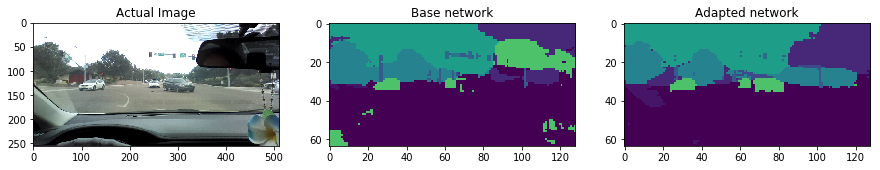

In [22]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(img_trnsfm(img.detach().cpu()[0]))
plt.title("Actual Image")

plt.subplot(1,3,2)
plt.imshow(fig_img1)
plt.title("Base network")

plt.subplot(1,3,3)
plt.imshow(fig_img2)
plt.title("Adapted network")
plt.show()

In [25]:
# To free memory
del op1, op2, base_network